In [1]:
import numpy as np
import keras
from keras import backend as k 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = '/home/bhush/Project/training/train'
valid_path = '/home/bhush/Project/training/valid'
test_path = '/home/bhush/Project/training/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dr','nodr'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dr','nodr'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dr','nodr'], batch_size=10)

Found 365 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 338 images belonging to 2 classes.


In [4]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs , labels = next(train_batches)

/home/bhush/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


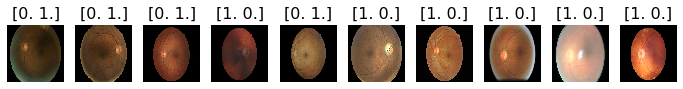

In [6]:
plots(imgs, titles=labels)

In [7]:
vgg16_model = keras.applications.vgg16.VGG16()

In [8]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [10]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [12]:
for layer in model.layers:
    layer.trainable = False 

In [13]:
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
H=model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
4/4 - 20s - loss: 0.6867 - accuracy: 0.5429 - val_loss: 0.8197 - val_accuracy: 0.4750
Epoch 2/5
4/4 - 22s - loss: 0.6961 - accuracy: 0.7250 - val_loss: 0.7748 - val_accuracy: 0.5000
Epoch 3/5
4/4 - 21s - loss: 0.7068 - accuracy: 0.6857 - val_loss: 0.7470 - val_accuracy: 0.6250
Epoch 4/5
4/4 - 21s - loss: 0.6228 - accuracy: 0.6500 - val_loss: 0.8101 - val_accuracy: 0.4750
Epoch 5/5
4/4 - 21s - loss: 0.6853 - accuracy: 0.6250 - val_loss: 0.6539 - val_accuracy: 0.5750


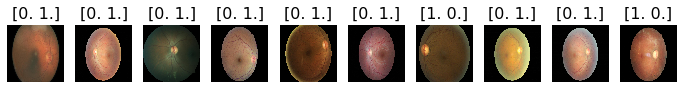

In [18]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [19]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.], dtype=float32)

In [20]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [21]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

Instructions for updating:
Please use Model.predict, which supports generators.


In [22]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[5 3]
 [2 0]]


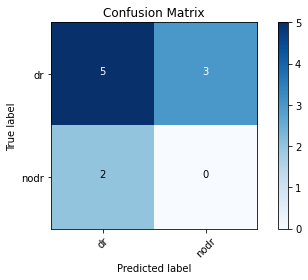

In [23]:
cm_plot_labels = ['dr','nodr']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [24]:
model.save('diabetic_retinopathy.h5')

In [25]:
pre=model.predict(test_batches)

Generating plots...


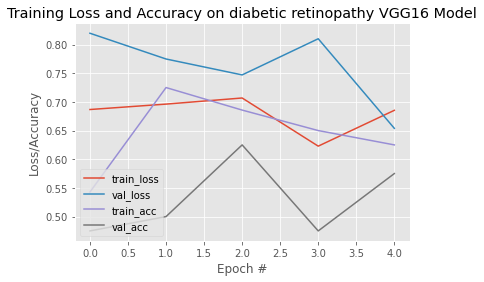

In [27]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
import matplotlib
print("Generating plots...")
#sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = 5
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy VGG16 Model")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")